# Light Field VR Data Analysis


## Read the raw data from .csv files

In [1]:
import pandas as pd
import os as os

# Get subject list from file names
data_dir='rawdata/'
files = os.listdir(data_dir)
subjects = [ f.split('_')[0] for f in files if 'votes.csv' in f ]

# Load the score data by subject
# Read votes from csv-files to Pandas DataFrames and concatenate
def read_votes(x):
    df = pd.read_csv(data_dir + x + '_votes.csv')
    df['Subject'] = x
    return df
df = pd.concat([ read_votes(s) for s in subjects ]).reset_index(drop=True)

# Parce stimulus names to Image, Codec and Bitrate
name_parsed = pd.DataFrame([ [s[:3],s[3:5],s[5:]] for s in df['Stimulus'] ],columns=['Image','Codec','Bitrate'])
df = df.merge(name_parsed,left_index=True, right_index=True)

dfExpData = df[['Subject','Stimulus','Image','Codec','Bitrate','Vote']]

dfExpData.to_csv('experiment_data.csv')

print("Number of subjects:",len(subjects))
#dfExpData.head() # Preview data table

Number of subjects: 17


## Perform outlier detection

    Outliers detections method is described in
    ITU-R BT.500-13 (2012): Section 2.3.1, Page 35


In [2]:
import numpy as np
import scipy.stats as ss
from functools import reduce

# Outlier detection

df = dfExpData # Get a copy of the data

# Calculate moments: mean, standard deviation, kurtosis per stimulus
ms = pd.DataFrame([(stimulus, votes.mean(), votes.std(),votes.kurtosis()) 
                   for stimulus, votes in df.groupby('Stimulus')['Vote']
                  ],
                  columns = ['Stimulus','Mean','Std','Kurt'])

pqs = list() # List if P[i] and Q[i]
for sub in subjects: # Iterate over subjects
    p,q = 0,0
    for _,m in ms.iterrows(): # Iterate over subject's votes
        v = int( df[(df.Subject == sub)&(df.Stimulus == m.Stimulus)]['Vote'] )
        stdcoeff = np.sqrt(20) if m.Kurt < 2 or m.Kurt > 4 else 2 # Consider normal distribution if Kurt is in [2..4]
        if v > m.Mean + m.Std*stdcoeff :  # If the vote is higher then interval
            p = p + 1                     # increment P
        if v < m.Mean - m.Std*stdcoeff :  # If the vote is lower then interval
            q = q + 1                     # increment Q
        #print(sub,m.Stimulus,np.round(m.Kurt,1),v,np.round(m.Mean-m.Std*stdcoeff,1),np.round(m.Mean+m.Std*stdcoeff,1),p,q)
    pqs.append((sub, p, q))
pqs = pd.DataFrame(pqs, columns=['Subject','P','Q'])

N = len(set(df['Stimulus'])) # Number of stimuli (aka number of votes per subject)

# If the number of outlying votes for a subject is > 5%
# and the difference between number of votes lying upper (P) and lower (Q)
# the specified interval is < 30% (i.e. outlying votes are rather balanced)
# consider the subject as an outlier
pqs['isOutlier'] = [(((s.P+s.Q)/N) > 0.05) and (abs((s.P-s.Q)/(s.P+s.Q)) < 0.3) for _,s in pqs.iterrows()]

# For DEBUG
#pqs.loc[2,'isOutlier'] = True
#pqs.loc[11,'isOutlier'] = True
#pqs.loc[13,'isOutlier'] = True

outliers = list(pqs[pqs.isOutlier]['Subject'])

print('Outliers detected:',len(outliers))
print(outliers)

# Remove outliers
if len(outliers):
    dfExpDataScreened = df[ [reduce((lambda x,y: x and y),z) for z in zip(*[df.Subject!=o for o in outliers])] ]
else:
    dfExpDataScreened = df
dfExpDataScreened.to_csv('experiment_data_screened.csv')


Outliers detected: 0
[]


## Plot mean opinion scores (MOS) with 95% confidence intervals (CI)

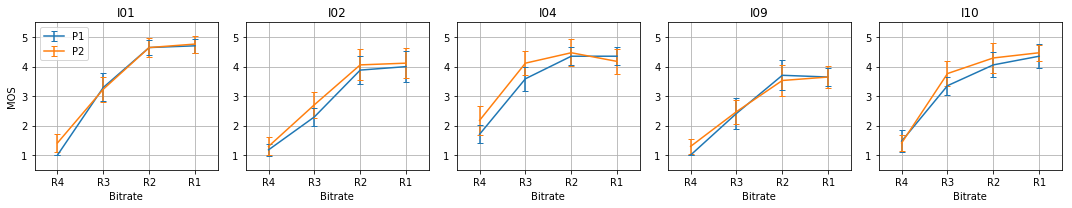

In [3]:
import matplotlib.pyplot as plt
import scipy.stats as ss

# Get a copy of the screened data
df = dfExpDataScreened

images = list(set(df.Image)); images.sort()
bitrates = list(set(df.Bitrate)); bitrates.sort()

# Calculate 95% confidence interval assuming Student's T distribution
def get_ci(xs):
    return ss.t.interval(0.95, len(xs)-1, loc=np.mean(xs),
                         scale=ss.sem(xs)) if ss.sem(xs) > 0 else (np.mean(xs),np.mean(xs))

# Draw a MOS (sub)plot for one LF image
def plot_mos_per_image(im, c = 'P1', n = 0):
    # Retrive data for an image 'im' and codec 'c' and group by bitrate
    xs = list(df[(df['Image'] == im)&(df['Codec'] == c)][['Bitrate','Vote','Codec']].groupby(['Bitrate']))
    # Calculate means for a stimulus data grouped by bitrate earlier
    means = list(map(lambda x: np.mean(x[1]['Vote']), xs))
    #errors = list(map(lambda x: get_ci(x[1]['Vote']), xs)) # Assuming errors
    #errors = list(map(lambda x: (x[1]-x[0])/2, errors))    # .... are symmetric
    errors = list(map(lambda x: abs(get_ci(x[1]['Vote'])-np.mean(x[1]['Vote'])), xs)) # General assymetric case
    errors = list(zip(*errors)) # Re-format the list to feed to matplotlib..errorbar
    x = list(range(len(bitrates),0,-1)) # Reverse the order because R1 is the highest bitrate
    plt.xticks(x, bitrates) # X-axis tick labels
    if n > 0 : plt.subplot(1, 5, n)
    plt.errorbar(x, means, yerr=errors, capsize=3)

# Perform drawing of the plots for MOS with CI
plt.subplots(1,5,figsize=(15,3))
for i,n in zip(images,range(1,6)):
    plot_mos_per_image(i, 'P1', n)
    plot_mos_per_image(i, 'P2', n)
    plt.grid(); plt.title(i)
    plt.ylim((0.5,5.5)); plt.xlim((0.5,4.5))
    plt.xlabel('Bitrate')
    if n==1 :
        plt.ylabel('MOS')
        plt.legend(['P1','P2'])

plt.tight_layout()
plt.savefig("Mos.pdf")
plt.savefig("Mos.png")

plt.show()

## Scripts for interaction analysis to be added...